<a href="https://colab.research.google.com/github/yulian-gilyazev/colab-notebooks/blob/main/inetune_gpt_j_6b_8bit-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Fine-tuning 6-Billion GPT-J in colab with LoRA and 8-bit compression

This notebook is a proof of concept for fine-tuning [GPT-J-6B](https://huggingface.co/EleutherAI/gpt-j-6B) with limited memory. A detailed explanation of how it works can be found in [this model card](https://huggingface.co/hivemind/gpt-j-6B-8bit).

In [ ]:
!pip install transformers==4.14.1
!pip install bitsandbytes
!pip install datasets==1.16.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.4 MB 7.0 MB/s 
     |████████████████████████████████| 163 kB 70.5 MB/s 
     |████████████████████████████████| 3.3 MB 42.1 MB/s 
     |████████████████████████████████| 880 kB 64.0 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=d0283a70250c888286120b77b70c3782dc399ad2e3dfde10c2d9db350838a1d6
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62.5 MB 1.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 298 kB 6.9 MB/s 
     |████████████████████████████████| 115 kB 45.9 MB/s 
  

In [ ]:
import transformers

import torch
import torch.nn.functional as F
from torch import nn
from torch.cuda.amp import custom_fwd, custom_bwd

from bitsandbytes.functional import quantize_blockwise, dequantize_blockwise

from tqdm.auto import tqdm


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
For effortless bug reporting copy-paste your error into this form: https://docs.google.com/forms/d/e/1FAIpQLScPB8emS3Thkp66nvqwmjTEgxp8Y9ufuWTzFyr9kJ5AoI47dQ/viewform?usp=sf_link
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching /usr/local/cuda/lib64...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 112
CUDA SETUP: Loading binary /usr/local/lib/python3.7/dist-packages/bitsandbytes/libbitsandbytes_cuda112.so...


/usr/local/lib/python3.7/dist-packages/bitsandbytes/cuda_setup/paths.py:106: UserWarning: /usr/lib64-nvidia did not contain libcudart.so as expected! Searching further paths...
  f'{candidate_env_vars["LD_LIBRARY_PATH"]} did not contain '
/usr/local/lib/python3.7/dist-packages/bitsandbytes/cuda_setup/paths.py:28: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('"/usr/local/bin/dap_multiplexer","enableLsp"'), PosixPath('true}'), PosixPath('["--ip=172.28.0.2"],"debugAdapterMultiplexerPath"'), PosixPath('6000,"kernelManagerProxyHost"'), PosixPath('"172.28.0.3","jupyterArgs"'), PosixPath('{"kernelManagerProxyPort"')}
  "WARNING: The following directories listed in your path were found to "
/usr/local/lib/python3.7/dist-packages/bitsandbytes/cuda_setup/paths.py:28: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/env/python')}
  "WARNING: The following directories lis

### Converting the model to 8 bits.

We convert EleutherAI's GPT-J-6B model to 8 bits using facebook's [bitsandbytes](https://github.com/facebookresearch/bitsandbytes) library. This reduces the model's size from 20Gb down to just 6Gb.

Note that we don't convert linear layer biases to 8 bit as they take up less that 1% of the model's weight anyway.

In [ ]:
class FrozenBNBLinear(nn.Module):
    def __init__(self, weight, absmax, code, bias=None):
        assert isinstance(bias, nn.Parameter) or bias is None
        super().__init__()
        self.out_features, self.in_features = weight.shape
        self.register_buffer("weight", weight.requires_grad_(False))
        self.register_buffer("absmax", absmax.requires_grad_(False))
        self.register_buffer("code", code.requires_grad_(False))
        self.adapter = None
        self.bias = bias
 
    def forward(self, input):
        output = DequantizeAndLinear.apply(input, self.weight, self.absmax, self.code, self.bias)
        if self.adapter:
            output = output + self.adapter(input)
        return output
 
    @classmethod
    def from_linear(cls, linear: nn.Linear) -> "FrozenBNBLinear":
        weights_int8, state = quantize_blockise_lowmemory(linear.weight)
        return cls(weights_int8, *state, linear.bias)
 
    def __repr__(self):
        return f"{self.__class__.__name__}({self.in_features}, {self.out_features})"
 
 
class DequantizeAndLinear(torch.autograd.Function): 
    @staticmethod
    @custom_fwd
    def forward(ctx, input: torch.Tensor, weights_quantized: torch.ByteTensor,
                absmax: torch.FloatTensor, code: torch.FloatTensor, bias: torch.FloatTensor):
        weights_deq = dequantize_blockwise(weights_quantized, absmax=absmax, code=code)
        ctx.save_for_backward(input, weights_quantized, absmax, code)
        ctx._has_bias = bias is not None
        return F.linear(input, weights_deq, bias)
 
    @staticmethod
    @custom_bwd
    def backward(ctx, grad_output: torch.Tensor):
        assert not ctx.needs_input_grad[1] and not ctx.needs_input_grad[2] and not ctx.needs_input_grad[3]
        input, weights_quantized, absmax, code = ctx.saved_tensors
        # grad_output: [*batch, out_features]
        weights_deq = dequantize_blockwise(weights_quantized, absmax=absmax, code=code)
        grad_input = grad_output @ weights_deq
        grad_bias = grad_output.flatten(0, -2).sum(dim=0) if ctx._has_bias else None
        return grad_input, None, None, None, grad_bias
 
 
class FrozenBNBEmbedding(nn.Module):
    def __init__(self, weight, absmax, code):
        super().__init__()
        self.num_embeddings, self.embedding_dim = weight.shape
        self.register_buffer("weight", weight.requires_grad_(False))
        self.register_buffer("absmax", absmax.requires_grad_(False))
        self.register_buffer("code", code.requires_grad_(False))
        self.adapter = None
 
    def forward(self, input, **kwargs):
        with torch.no_grad():
            # note: both quantuized weights and input indices are *not* differentiable
            weight_deq = dequantize_blockwise(self.weight, absmax=self.absmax, code=self.code)
            output = F.embedding(input, weight_deq, **kwargs)
        if self.adapter:
            output += self.adapter(input)
        return output 
 
    @classmethod
    def from_embedding(cls, embedding: nn.Embedding) -> "FrozenBNBEmbedding":
        weights_int8, state = quantize_blockise_lowmemory(embedding.weight)
        return cls(weights_int8, *state)
 
    def __repr__(self):
        return f"{self.__class__.__name__}({self.num_embeddings}, {self.embedding_dim})"
 
 
def quantize_blockise_lowmemory(matrix: torch.Tensor, chunk_size: int = 2 ** 20):
    assert chunk_size % 4096 == 0
    code = None
    chunks = []
    absmaxes = []
    flat_tensor = matrix.view(-1)
    for i in range((matrix.numel() - 1) // chunk_size + 1):
        input_chunk = flat_tensor[i * chunk_size: (i + 1) * chunk_size].clone()
        quantized_chunk, (absmax_chunk, code) = quantize_blockwise(input_chunk, code=code)
        chunks.append(quantized_chunk)
        absmaxes.append(absmax_chunk)
 
    matrix_i8 = torch.cat(chunks).reshape_as(matrix)
    absmax = torch.cat(absmaxes)
    return matrix_i8, (absmax, code)
 
 
def convert_to_int8(model):
    """Convert linear and embedding modules to 8-bit with optional adapters"""
    for module in list(model.modules()):
        for name, child in module.named_children():
            if isinstance(child, nn.Linear):
                print(name, child)
                setattr( 
                    module,
                    name,
                    FrozenBNBLinear(
                        weight=torch.zeros(child.out_features, child.in_features, dtype=torch.uint8),
                        absmax=torch.zeros((child.weight.numel() - 1) // 4096 + 1),
                        code=torch.zeros(256),
                        bias=child.bias,
                    ),
                )
            elif isinstance(child, nn.Embedding):
                setattr(
                    module,
                    name,
                    FrozenBNBEmbedding(
                        weight=torch.zeros(child.num_embeddings, child.embedding_dim, dtype=torch.uint8),
                        absmax=torch.zeros((child.weight.numel() - 1) // 4096 + 1),
                        code=torch.zeros(256),
                    )
                )

In [ ]:
class GPTJBlock(transformers.models.gptj.modeling_gptj.GPTJBlock):
    def __init__(self, config):
        super().__init__(config)

        convert_to_int8(self.attn)
        convert_to_int8(self.mlp)


class GPTJModel(transformers.models.gptj.modeling_gptj.GPTJModel):
    def __init__(self, config):
        super().__init__(config)
        convert_to_int8(self)
        

class GPTJForCausalLM(transformers.models.gptj.modeling_gptj.GPTJForCausalLM):
    def __init__(self, config):
        super().__init__(config)
        convert_to_int8(self)


transformers.models.gptj.modeling_gptj.GPTJBlock = GPTJBlock  # monkey-patch GPT-J

In [ ]:
config = transformers.GPTJConfig.from_pretrained("EleutherAI/gpt-j-6B")
tokenizer = transformers.AutoTokenizer.from_pretrained("EleutherAI/gpt-j-6B")

Downloading:   0%|          | 0.00/930 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/619 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.94k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/357 [00:00<?, ?B/s]

In [ ]:
gpt = GPTJForCausalLM.from_pretrained("hivemind/gpt-j-6B-8bit", low_cpu_mem_usage=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
gpt.to(device)

Downloading:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.75G [00:00<?, ?B/s]

k_proj Linear(in_features=4096, out_features=4096, bias=False)
v_proj Linear(in_features=4096, out_features=4096, bias=False)
q_proj Linear(in_features=4096, out_features=4096, bias=False)
out_proj Linear(in_features=4096, out_features=4096, bias=False)
fc_in Linear(in_features=4096, out_features=16384, bias=True)
fc_out Linear(in_features=16384, out_features=4096, bias=True)
k_proj Linear(in_features=4096, out_features=4096, bias=False)
v_proj Linear(in_features=4096, out_features=4096, bias=False)
q_proj Linear(in_features=4096, out_features=4096, bias=False)
out_proj Linear(in_features=4096, out_features=4096, bias=False)
fc_in Linear(in_features=4096, out_features=16384, bias=True)
fc_out Linear(in_features=16384, out_features=4096, bias=True)
k_proj Linear(in_features=4096, out_features=4096, bias=False)
v_proj Linear(in_features=4096, out_features=4096, bias=False)
q_proj Linear(in_features=4096, out_features=4096, bias=False)
out_proj Linear(in_features=4096, out_features=4096, 

GPTJForCausalLM(
  (transformer): GPTJModel(
    (wte): FrozenBNBEmbedding(50400, 4096)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0): GPTJBlock(
        (ln_1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (attn): GPTJAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (k_proj): FrozenBNBLinear(4096, 4096)
          (v_proj): FrozenBNBLinear(4096, 4096)
          (q_proj): FrozenBNBLinear(4096, 4096)
          (out_proj): FrozenBNBLinear(4096, 4096)
        )
        (mlp): GPTJMLP(
          (fc_in): FrozenBNBLinear(4096, 16384)
          (fc_out): FrozenBNBLinear(16384, 4096)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
      (1): GPTJBlock(
        (ln_1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (attn): GPTJAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0

### Text generation example

In [ ]:
prompt = tokenizer("A cat sat on a mat", return_tensors='pt')
prompt = {key: value.to(device) for key, value in prompt.items()}
out = gpt.generate(**prompt, min_length=128, max_length=128, do_sample=True)
tokenizer.decode(out[0])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'A cat sat on a mat in front of me. The cat’s coat was the color of mahogany, but it still glowed in the dim light, so even though the mat was a pale yellow, the cat’s black eyes shone. The cat fixed me with its brown gaze.\n\nI had been in the apartment for about five hours. The apartment was about two rooms in size, and was occupied by a family with two young children, a toddler and a preschool boy. The two children and their four siblings shared two rooms, and the parents slept with one of the children in one of the rooms'

### LoRA fine-tuning example
Here we demonstrate how to fine-tune the proposed model using low-rank adapters [(Hu et al, 2021)](https://arxiv.org/abs/2106.09685) and [8-bit Adam](https://arxiv.org/abs/2110.02861). We also use [dataset streaming API](https://huggingface.co/docs/datasets/dataset_streaming.html) to avoid downloading the large dataset.

In [ ]:
class CopyTensor(nn.Module):
  def __init__(self):
    super().__init__()
  def forward(self, X):
    return X.clone()

def add_adapters(model, adapter_dim=16):
    assert adapter_dim > 0

    for module in model.modules():
        if isinstance(module, FrozenBNBLinear):
            module.adapter = nn.Sequential(
                nn.Linear(module.in_features, adapter_dim, bias=False),
                nn.Linear(adapter_dim, module.out_features, bias=False),
            )
            nn.init.zeros_(module.adapter[1].weight)
        elif isinstance(module, FrozenBNBEmbedding):
            module.adapter = nn.Sequential(
                nn.Embedding(module.num_embeddings, adapter_dim),
                nn.Linear(adapter_dim, module.embedding_dim, bias=False),
            )
            nn.init.zeros_(module.adapter[1].weight)

add_adapters(gpt)
gpt.to(device)

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output


In [ ]:
def plot_metrics(metrics_dict, last_to_show=30):
    n = len(metrics_dict)
    clear_output(True)
    plt.figure(figsize=(20, 10))
    for i, (metric_name, metric_values) in enumerate(metrics_dict.items()):
        plt.subplot(2, n, i + 1)
        plt.title(metric_name)
        plt.plot(metric_values, label=metric_name)
        plt.legend()
    for i, (metric_name, metric_values) in enumerate(metrics_dict.items()):
        plt.subplot(2, n, n + i + 1)
        plt.title(f'{metric_name} last {last_to_show} values')
        plt.plot(metric_values[-last_to_show:], label=metric_name)
        plt.legend()
    plt.show()

In [ ]:
params_for_optimizer = [
    name for name, param in gpt.named_parameters()
    if "attn" in name and "adapter" in name
]
print("Trainiable params:", len(params_for_optimizer))


Trainiable params: 224


In [ ]:
# and after you verified it:
for name, param in gpt.named_parameters():
    if name not in params_for_optimizer:
        print(f"Setting {name} requires_grad=False")
        param.requires_grad = False
    else:
        param.requires_grad = True

Setting transformer.wte.adapter.0.weight requires_grad=False
Setting transformer.wte.adapter.1.weight requires_grad=False
Setting transformer.h.0.ln_1.weight requires_grad=False
Setting transformer.h.0.ln_1.bias requires_grad=False
Setting transformer.h.0.mlp.fc_in.bias requires_grad=False
Setting transformer.h.0.mlp.fc_in.adapter.0.weight requires_grad=False
Setting transformer.h.0.mlp.fc_in.adapter.1.weight requires_grad=False
Setting transformer.h.0.mlp.fc_out.bias requires_grad=False
Setting transformer.h.0.mlp.fc_out.adapter.0.weight requires_grad=False
Setting transformer.h.0.mlp.fc_out.adapter.1.weight requires_grad=False
Setting transformer.h.1.ln_1.weight requires_grad=False
Setting transformer.h.1.ln_1.bias requires_grad=False
Setting transformer.h.1.mlp.fc_in.bias requires_grad=False
Setting transformer.h.1.mlp.fc_in.adapter.0.weight requires_grad=False
Setting transformer.h.1.mlp.fc_in.adapter.1.weight requires_grad=False
Setting transformer.h.1.mlp.fc_out.bias requires_gra

In [ ]:
from datasets import load_dataset

dataset = load_dataset("bavard/personachat_truecased", streaming=True)

Downloading:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.47k [00:00<?, ?B/s]

In [ ]:
import itertools
import pandas as pd
import numpy as np

In [ ]:
dummy_persona_chat_ds = pd.DataFrame(itertools.islice(dataset['train'], 0, 1000))

In [ ]:
dummy_persona_chat_ds.iloc[0]['candidates']

['My mom was single with 3 boys, so we never left the projects.',
 'I try to wear all black every day. It makes me feel comfortable.',
 'Well nursing stresses you out so I wish luck with sister.',
 'Yeah just want to pick up Nba nfl getting old.',
 'I really like Celine Dion. What about you?',
 'No. I live near farms.',
 "I wish I had a daughter, I'm a boy mom. They're beautiful boys though still lucky.",
 'Yeah when I get bored I play gone with the wind my favorite movie.',
 "Hi how are you? I'm eating dinner with my hubby and 2 kids.",
 'Were you married to your high school sweetheart? I was.',
 'That is great to hear! Are you a competitive rider?',
 "Hi, I'm doing ok. I'm a banker. How about you?",
 "I'm 5 years old.",
 'Hi there. How are you today?',
 'I totally understand how stressful that can be.',
 'Yeah sometimes you do not know what you are actually watching.',
 'Mother taught me to cook! We are looking for an exterminator.',
 'I enjoy romantic movie. What is your favorite se

In [ ]:
dummy_persona_chat_ds.iloc[1]['personality'], dummy_persona_chat_ds.iloc[2]['history'], 

(['I like to remodel homes.',
  'I like to go hunting.',
  'I like to shoot a bow.',
  'My favorite holiday is halloween.'],
 ["Hi, how are you doing? I'm getting ready to do some cheetah chasing to stay in shape.",
  'You must be very fast. Hunting is one of my favorite hobbies.',
  'I am! For my hobby I like to do canning or some whittling.',
  'I also remodel homes when I am not out bow hunting.',
  "That's neat. When I was in high school I placed 6th in 100m dash!"])

In [ ]:
from transformers.utils.dummy_pt_objects import ReformerModelWithLMHead
class PersonaChatDataSet:
    def __init__(self, row_dataset):
        self.row_dataset = row_dataset

    def __len__(self):
        return len(self.dataset)

    def _shuffle(self):
        self.indexes = np.arange(0, self.__len__())
        np.random.shuffle(self.indexes)

    def __getitem__(self, idx):
        row = self.row_dataset.iloc[self.indexes[idx]]
        return row

    def groupby(self, cols):
        grouped_ds = self.row_dataset.groupby(cols)
        return 
        

In [ ]:
class InferenceWithPromptGenerator:
    def __init__(self, model=gpt, tokenizer=tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        self.max_length = 512
        self.seq_length = 128
    def generate(self, personality, history):
        for i in range(1, 10):
            prompt_s = ' '.join(personality) + '\n' + '\n'.join([f'B:{item}' if i % 2 else f'A:{item}' for i, item in enumerate(history[:-i])])
            if len(prompt_s) > self.max_length:
                if len(history) > i + 1:
                    continue
                else:
                    break
            else:
                break
        prompt = self.tokenizer(prompt_s, return_tensors='pt')
        prompt = {key: value.to(device) for key, value in prompt.items()}
        out = gpt.generate(**prompt, min_length=len(prompt) + self.seq_length // 4, max_length=len(prompt) + self.seq_length, do_sample=True)
        return self.tokenizer.decode(out[0]), prompt_s 

In [ ]:
generator = InferenceWithPromptGenerator()

In [ ]:
result, prompt = generator.generate(dummy_persona_chat_ds.iloc[50]['personality'], dummy_persona_chat_ds.iloc[50]['history'])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
print(result, '\n' * 4, prompt)

I like to remodel homes. I like to go hunting. I like to shoot a bow. My favorite holiday is halloween.
A:Hi, how are you doing? I'm getting ready to do some cheetah chasing to stay in shape.
B:You must be very fast. Hunting is one of my favorite hobbies. I hunt my deer, pheasant, and turkey. A:It's a good sport on a beautiful spring day. What do you think you'll do for the holiday this year?
B:Halloween is one of my favorite holidays. I dress up in my favorite costume and go 



 I like to remodel homes. I like to go hunting. I like to shoot a bow. My favorite holiday is halloween.
A:Hi, how are you doing? I'm getting ready to do some cheetah chasing to stay in shape.
B:You must be very fast. Hunting is one of my favorite hobbies.


In [ ]:
def generate_prompt(personality, history, candidates)

In [ ]:
dummy_persona_chat_ds.head(50)

,personality,candidates,history,conv_id,utterance_idx
0,"[I like to remodel homes., I like to go huntin...","[My mom was single with 3 boys, so we never le...","[Hi, how are you doing? I'm getting ready to d...",0,0
1,"[I like to remodel homes., I like to go huntin...","[Hello I am doing well how are you?, Ll someth...","[Hi, how are you doing? I'm getting ready to d...",0,1
2,"[I like to remodel homes., I like to go huntin...","[Yes they do but I say no to them lol., I have...","[Hi, how are you doing? I'm getting ready to d...",0,2
3,"[I like to remodel homes., I like to go huntin...","[Not really, it is just a small local radio st...","[Hi, how are you doing? I'm getting ready to d...",0,3
4,"[I like to remodel homes., I like to go huntin...","[I am listening to system of a down, I wonder ...","[Hi, how are you doing? I'm getting ready to d...",0,4
5,"[I like to remodel homes., I like to go huntin...","[That sounds nice. Do you make your own?, I ha...","[Hi, how are you doing? I'm getting ready to d...",0,5
6,"[I like to remodel homes., I like to go huntin...","[Awesome. So what do you do for a living?, You...","[Hi, how are you doing? I'm getting ready to d...",0,6
7,"[My mom is my best friend., I have four sister...","[There was one person better than me, but I wi...","[Hi, how are you doing today?]",1,0
8,"[My mom is my best friend., I have four sister...",[That would be great. What do you do on the we...,"[Hi, how are you doing today?, I am spending t...",1,1
9,"[My mom is my best friend., I have four sister...","[Very long, she was with me when I colored my ...","[Hi, how are you doing today?, I am spending t...",1,2


In [ ]:
for item in dataset['train']:
    print(item)
    break

{'personality': ['I like to remodel homes.', 'I like to go hunting.', 'I like to shoot a bow.', 'My favorite holiday is halloween.'], 'candidates': ['My mom was single with 3 boys, so we never left the projects.', 'I try to wear all black every day. It makes me feel comfortable.', 'Well nursing stresses you out so I wish luck with sister.', 'Yeah just want to pick up Nba nfl getting old.', 'I really like Celine Dion. What about you?', 'No. I live near farms.', "I wish I had a daughter, I'm a boy mom. They're beautiful boys though still lucky.", 'Yeah when I get bored I play gone with the wind my favorite movie.', "Hi how are you? I'm eating dinner with my hubby and 2 kids.", 'Were you married to your high school sweetheart? I was.', 'That is great to hear! Are you a competitive rider?', "Hi, I'm doing ok. I'm a banker. How about you?", "I'm 5 years old.", 'Hi there. How are you today?', 'I totally understand how stressful that can be.', 'Yeah sometimes you do not know what you are actu

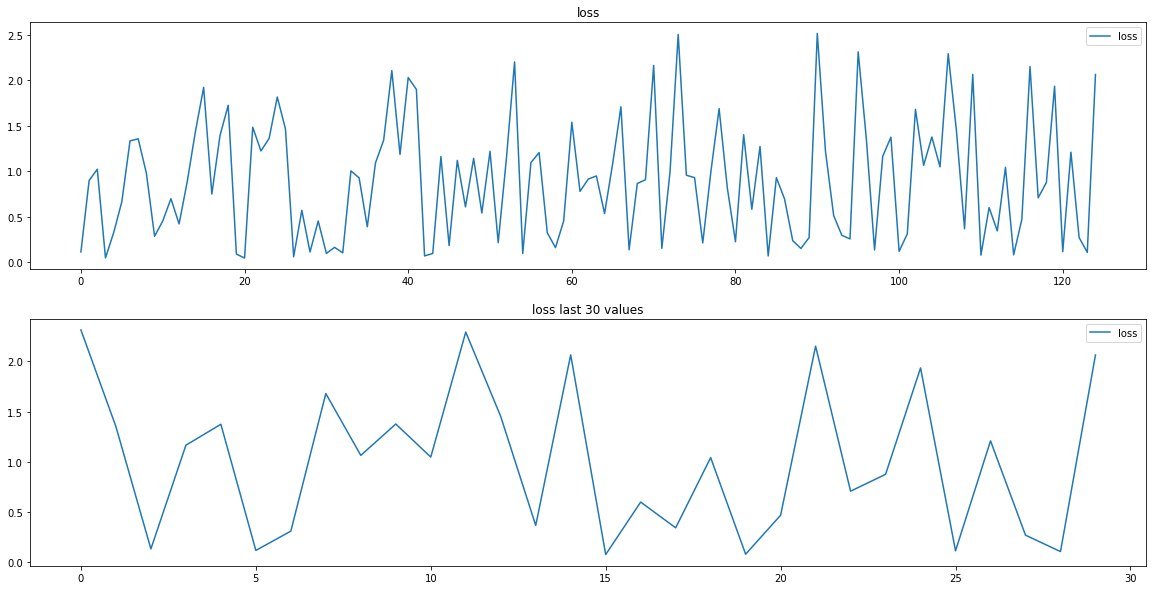

KeyboardInterrupt: ignored

In [ ]:
from datasets import load_dataset
from bitsandbytes.optim import Adam8bit

gpt.gradient_checkpointing_enable()
from datasets import load_dataset

dataset = load_dataset("bavard/personachat_truecased", stre)

codeparrot = load_dataset("transformersbook/codeparrot-train", streaming=True)
optimizer = Adam8bit(gpt.parameters(), lr=1e-5)

metrics_dict = {'loss': []}

with torch.cuda.amp.autocast():
    for row in tqdm(codeparrot["train"]):
        if len(row["content"]) <= 1:
            continue

        batch = tokenizer(row["content"], truncation=True, max_length=128, return_tensors='pt')
        batch = {k: v.cuda() for k, v in batch.items()}

        out = gpt.forward(**batch,)

        loss = F.cross_entropy(out.logits[:, :-1, :].flatten(0, -2), batch['input_ids'][:, 1:].flatten(),
                               reduction='mean')
        metrics_dict['loss'].append(loss.detach().cpu().numpy())
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        plot_metrics(metrics_dict)

This training loop is just a proof of concept - to show that even in the heaviest case, it still fits on a gpu.
Depending on your finetuning task, you'll need to remove some parts.
Below we explain how to modify the code to achieve the setup from the [LoRA paper](https://arxiv.org/pdf/2106.09685.pdf)

If you wanna fine-tune a-la LoRA , please use the parameters from Table 11,12 and 15 as a starter:

(1) Train only the adapter matrices from attention layers

In the above example, we train all kinds of adapters, and also layernorm scales and biases. This is only useful for fine-tuning over reasonably large datasets over long time.
For quick setups you should tag everything except **the attention adapters** as `requires_grad=False` -- or just don't feed them into Adam:

```

params_for_optimizer = [
    param for name, param in model.named_parameters()
    if "attn" in name and "adapter" in name
]
print("Trainiable params:", len(params_for_optimizer))

# and after you verified it:
for name, param in model.named_parameters():
    if param not in params_for_optimizer:
        print(f"Setting {name} requires_grad=False")
        param.requires_grad = False
```

An even better way is to only create adapters that you need by modifying the `add_adapters` function above:
```
for name, module in model.named_modules():
    if isinstance(module, (FrozenBNBLinear, FrozenBNBEmbedding)):
        if "attn" in name:
            print("Adding adapter to", name)

            todo_initialize_adapters_like_in_notebook()
        else:
            print("Not adding adapter to", name)
```
As a side-effect, that would actually somewhat reduce the memory usage and may let you fit a longer sequence (e.g. 256)


(2) initialize the second adapter matrix with zeros
```
for name, module in model.named_modules():
    if hasattr(module, "adapter"):
        print("Initializing", name)
        nn.init.zeros_(module.adapter[1].weight)
        # optional: scale adapter[0].weight by (LoRA_alpha / r)
```

(3) use warmup and weight decay in Adam:
```
optimizer = Adam8Bit(..., weight_decay=0.01)
scheduler = transformers.get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps_from_paper(), expected_total_number_of_steps
)

actually_use_scheduler_in_training_loop()
```

Finally, we recommend modifying training loop to track the training metrics, saving the best checkpoint, etc.